# Pré-Processamento dos Dados e Aplicação dos Algoritmos ML

In [2]:
!pip install hampel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hampel: filename=hampel-1.0.2-cp310-cp310-linux_x86_64.whl size=208997 sha256=268c4cb9ed52c0b6e64bddaad9d3975f51db0e73a6a72e2ef78d62b8f8ba26b7
  Stored in directory: /root/.cache/pip/wheels/0e/c3/3c/8a9f55c3de0b09faf919393d4c6f09b11b7421dcaa7243b820
Successfully built hampel


In [ ]:
from scipy.fft import fftfreq, rfftfreq
import matplotlib.pyplot as plt
from scipy.fft import fft, rfft
from datetime import datetime
from hampel import hampel
import matplotlib.colors
import requests as rq
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os

---

Importando o código de carregamento dos dados e adequação do `timestamp`

In [ ]:
url = 'https://raw.githubusercontent.com/josewilsonsouza/Machine_Learing_INMETRO/main/TimeStamp/TimeStamp.py'
res = rq.get(url)

with open('TimeStamp.py', 'wb') as f:
    f.write(res.content)

In [ ]:
from TimeStamp import TimeStep as ts # Importando o codigo do TimeStamp

In [ ]:
df1 = ts('1').time_step()
df2 = ts('2').time_step()
df3 = ts('3').time_step()

Distribuição dos `Dados`

In [ ]:
def distribution(num_sample = '1'):
  '''
  Distribuição dos dados.
  '''
  df = ts(num_sample).time_step()
  labels = ts(num_sample).labels

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

  for ax,lab in zip([ax1, ax2, ax3], labels):
    [ax.hist(df.loc[df['label']==lab][var], bins=50, label=var) for var in ['y','x','z']]; ax.legend(); ax.set_title(lab); # distribuição dos dados
    fig.suptitle('Distribuição - Amostra ' + num_sample)

  plt.savefig(f'Distribution_Sample_{num_sample}.pdf',format='pdf', bbox_inches='tight', pad_inches=0)

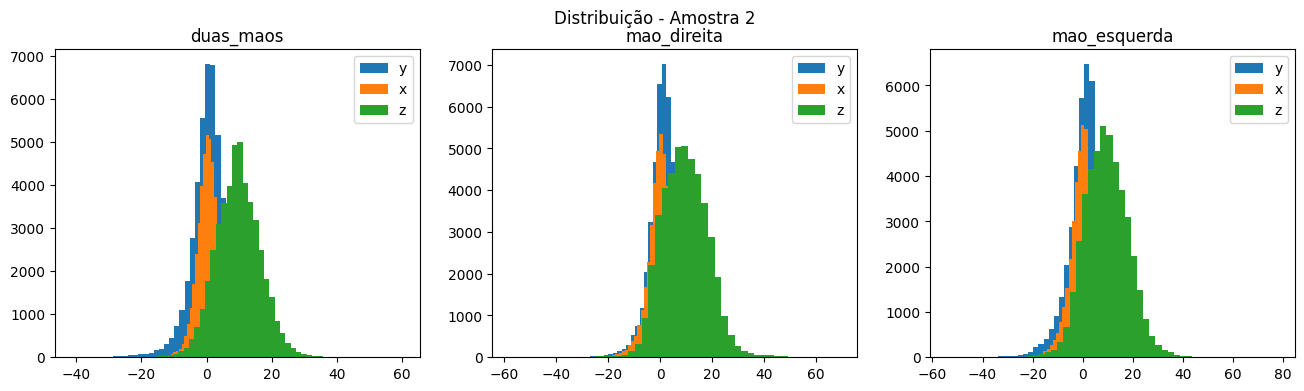

In [ ]:
distribution('2')

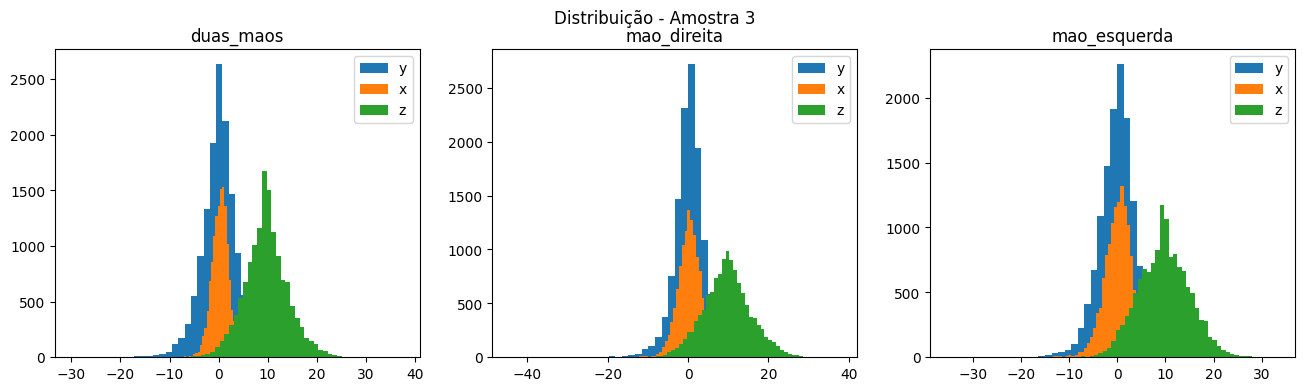

In [ ]:
distribution('3')

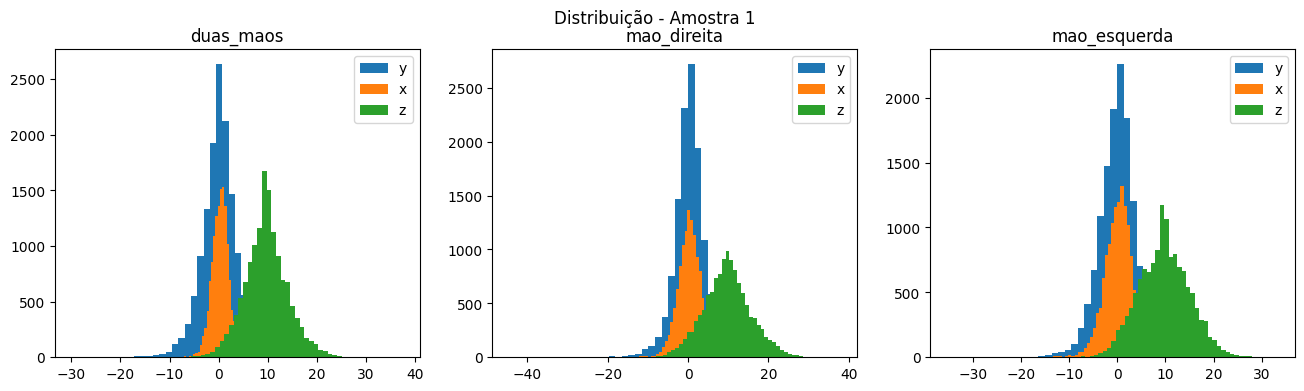

In [ ]:
distribution('1')

Eliminação de frequências altas do sinal

In [ ]:
def filter(df, filter='hampel', win_size=10, n_sigma=5):
    '''
    Função que aplica um filtro aos dados.
    Parâmetros:
      - df: data frame com as variáveis
      - filter: 'hampel', 'media_movel' ou 'fourier'
    Retorno:
      - DataFrame filtrado
    '''
    cols = ['x','y','z']
    df_filter = pd.DataFrame()

    for label in df.label.unique():
        dr = df.loc[df.label==label][cols].copy()

        if filter == 'media_movel':
          dr = dr.rolling(win_size, min_periods=1).mean()

        elif filter == 'hampel':
          dr = dr.apply(lambda x: hampel(x).filtered_data, axis=0)

        else:
          dr = fft(dr)
          dr = pd.DataFrame(dr).rename(columns = {0:'x',1:'y',2:'z'})

        dr['label']=label
        df_filter = pd.concat([df_filter, dr])

    return df_filter

`Janela Deslizante` com `Sobreposição`

In [ ]:
def sliding_window(df, window_size, overlap):
    """
    Aplica o método da janela deslizante com sobreposição. Esse código não faz distinção
    para tamanhos de janelas diferentes para labels diferentes.

    Parâmetros:
        - df: DataFrame filtrado contendo as colunas de aceleração dos eixos x, y e z.
        - window_size: Tamanho da janela em número de linhas.
        - overlap: Fração de sobreposição entre janelas (0 a 1).

    Retorna:
        - Um DataFrames segmentado em janelas.
    """
    id = 1

    df_all_labels = pd.DataFrame()

    for label in df['label'].unique():

      df_label = df[df.label == label].copy()
      overlap_size = int(window_size * overlap)

      windows = []
      start_index = 0

      while start_index < len(df_label):

        end_index = min(start_index + window_size, len(df_label))
        window_df = df_label.iloc[start_index:end_index].copy()
        window_df.loc[:,'id'] = id

        windows.append(window_df)
        start_index += window_size - overlap_size
        id += 1

      df_label_seg = pd.concat(windows)

      df_all_labels = pd.concat([df_all_labels, df_label_seg])
      id = id

    return df_all_labels

---

In [ ]:
def features(df):
  '''
  Função que gera as features para aplicação dos algoritimos de ML.
  Parâmetros:
    - DataFrame já pré-processado com os valores de aceleração dos três eixos.
  Retorno:
    - Um df com as features.
  '''
  labels = df.label.unique()

  axis, Metrics = ['x','y','z'], ['bin','max','min','mean','median','var','std','mad']
  df_trat = pd.DataFrame()

  for label in labels:

    df_label = df[df["label"] == label].copy()
    ids_label_windows = df_label["id"].unique() # Todas as ids das janelas para a label do loop

    cont = 0

    for window in range(len(df_trat), len(df_trat) + len(ids_label_windows)):

      df_trat.loc[window, 'label'] = label

      # calculando as features: maximo, minimo, binomial, media, mediana, variancia, desvp, mad
      for a in axis:

        serie = df_label[df_label.id == ids_label_windows[cont]][a]

        for metric  in Metrics:

          if metric == 'bin':
            df_trat.loc[window, metric+a.upper()] = (serie.max() - serie.min())/10
          elif metric == 'mad':
            df_trat.loc[window, metric+a.upper()] = (serie - serie.mean()).abs().mean()
          else:
            OutherMetric = getattr(np, metric)
            df_trat.loc[window, metric+a.upper()] = OutherMetric(serie)

      #df_trat.loc[window, 'meanT'] = df_label[df_label.id == ids_label_windows[cont]]['t'].mean()

      cont+=1

  return df_trat

Outras features de teste, que não usam segmentação

In [ ]:
def features_test(df):
  '''
  Função que gera as features para aplicação dos algoritimos de ML.
  Parâmetros:
    - DataFrame
  Retorno:
    - Um df com as features.
  '''
  labels = df.label.unique()

  df = df.assign(acc = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2),  )

---

### Aplicando os Algoritmos de Machine Learing

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn import metrics
import itertools

---

In [ ]:
def data_train_test(num_sample, filtro='hampel', win_size=100, overlap=0.3, n_sigma=3, size_sample=80, rdn_state=42, n_components=None):
    '''
    Função para tratar os dados e obter os valores de treino e teste.
    Entrada:
      num_sample (str) : string do número da amostra estudada ('1', '2', ou '3')
      filtro (str) : string com o nome do filtro ('media_movel', 'hampel')
      win_size (int) : tamanho da janela que o filtro usará
      overlap (float) : taxa de sobreposição, [0, 1]
      n_sigma (int) : para o caso 'hampel'
      size_sample (int) : tamanho da amostra desejada (janela deslizante)
      rdn_state (int) : semente aleatória
      n_components (int) : número de componentes principais para PCA (se None, não aplica PCA)
    '''
    df = ts(num_sample).time_step()

    dfilter = filter(df, filtro, win_size, n_sigma)
    ds = sliding_window(dfilter, size_sample, overlap)

    df_trat = features(ds)
    df_trat = df_trat.round(5)

    labels = df_trat.label.unique()
    df_trat["label"] = df_trat["label"].astype('category')
    df_trat["label"] = df_trat["label"].cat.rename_categories(labels)
    df_trat["label"] = df_trat["label"].cat.codes # Categorizando as labels

    df_shuffled = df_trat.sample(frac=1, random_state=rdn_state).reset_index(drop=True) # Embaralhando os dados

    df_input = df_shuffled.drop(columns=['label']).copy() # Definindo a entrada (input ou features)
    df_output = df_shuffled['label'].copy() # Definindo a saida (output ou labels)

    X = df_input.values
    Y = df_output.values

    smt = SMOTE(random_state = rdn_state) # Para balancear os dados
    X, Y = smt.fit_resample(X, Y)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = rdn_state)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    if n_components:
        pca = PCA(n_components=n_components)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)

    return X_train, X_test, y_train, y_test, labels

In [ ]:
from re import L
class MLInmetro:
  '''
  Provê diversos algoritmos de Machine Learing voltados para aplicação com os dados do Inmetro.
  '''
  def __init__(self, X_train, X_test, y_train, y_test, labels, random_state = 42):

    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test
    self.labels = labels
    self.random_state = random_state

  def KNN(self, k=5):
    '''
    Função que implementa o algoritmo KNN.
    '''

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(self.X_train, self.y_train)

    y_pred = knn.predict(self.X_test)

    Accuracy_KNN = metrics.accuracy_score(self.y_test, y_pred)
    Score_KNN = f1_score(self.y_test, y_pred, average='weighted')

    return Accuracy_KNN, Score_KNN, y_pred

  def SVM(self, ker = 'rbf'):
    '''
    Função que implementa o algoritmo SVM.
    '''

    clf = svm.SVC(kernel = ker, random_state=self.random_state)
    clf.fit(self.X_train, self.y_train)

    yhat = clf.predict(self.X_test)

    Accuracy_SVM = metrics.accuracy_score(self.y_test, yhat)
    Score_SVM = f1_score(self.y_test, yhat, average='weighted')

    return Accuracy_SVM, Score_SVM, yhat

  def RandomForest(self, n_estimators=100):
    '''
    Função que implementa o algoritmo Random Forest.
    '''

    rf = RandomForestClassifier(n_estimators = n_estimators, random_state=self.random_state)
    rf.fit(self.X_train, self.y_train)

    pred_rf = rf.predict(self.X_test)

    Accuracy_rf = metrics.accuracy_score(self.y_test, pred_rf)
    Score_rf = f1_score(self.y_test, pred_rf, average = 'weighted')

    return Accuracy_rf, Score_rf, pred_rf

  def DecisionTree(self):
    '''
    Função que implementa o algoritmo Decision Tree.
    '''

    decision_tree_classifier = DecisionTreeClassifier(random_state=self.random_state)
    decision_tree_classifier.fit(self.X_train, self.y_train)

    y_pred_dt = decision_tree_classifier.predict(self.X_test)

    Accuracy_dt = metrics.accuracy_score(self.y_test, y_pred_dt)
    Score_dt = f1_score(self.y_test, y_pred_dt, average = 'weighted')

    return Accuracy_dt, Score_dt, y_pred_dt

  def ConfusionMatrix(self, y_pred, name):
    '''
    Função que plota a matriz de confusão para o classificador repassado.
    '''
    cm = confusion_matrix(self.y_test, y_pred)

    # Plotar a matriz de confusão
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.labels, yticklabels=self.labels)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusão - {name}')
    plt.savefig(f'Confusion_Matrix_{name}.pdf', bbox_inches='tight', pad_inches=0)

  def CrossValidation(self, k=5):
    '''
    Função que realiza a validação cruzada para um classificador especificado.
    '''

    lasso = Linear
    # Realizar a validação cruzada
    scores = cross_val_score(classifier, self.X_train, self.y_train, cv=k)

    return scores

In [ ]:
def train_and_evaluate(num_sample, filtro='media_movel', win_size=250, overlap=0.4, n_sigma=3, size_sample=250, rdn_state=42, n_components=None):
  X_train, X_test, y_train, y_test, labels = data_train_test(num_sample, filtro, win_size, overlap, n_sigma, size_sample, rdn_state, n_components)
  ml_inmetro = MLInmetro(X_train, X_test, y_train, y_test, labels)

  results = []

  classifiers = ['RandomForest', 'DecisionTree']
  for clf in classifiers:
      scores = ml_inmetro.CrossValidation(clf, k=10)
      results.append([clf, scores.mean(), scores.std()])

  return results

In [ ]:
train_and_evaluate('1', filtro='media_movel', win_size=230, overlap=0.4, n_sigma=3, size_sample=250)

InvalidParameterError: The 'estimator' parameter of check_scoring must be an object implementing 'fit'. Got <bound method MLInmetro.RandomForest of <__main__.MLInmetro object at 0x7915e3ac5720>> instead.

# Testes

In [ ]:
possible_filters = ['media_movel', 'hampel']
possible_win_size_media_movel = range(50, 250, 20)
possible_win_size_hampel = range(10, 20, 2)
possible_n_sigma = range(3, 15)
possible_size_sample = range(40, 270 , 30)

In [ ]:
df_testes = pd.DataFrame()

for filtro in possible_filters:

  if filtro == 'media_movel':
    wins_size = possible_win_size_media_movel
  else:
    wins_size = possible_win_size_hampel

  for wsize in wins_size:
    for size in possible_size_sample:
      for sobrep in [0.20, 0.30, 0.40]:

        X_train, X_test, y_train, y_test, labels = data_train_test('1', filtro = filtro, win_size = wsize, overlap=sobrep, n_sigma=3, size_sample = size, rdn_state=42)
        MLS = MLInmetro(X_train, X_test, y_train, y_test, labels)

        temp_results = pd.DataFrame({
            'Accuracy_KNN': [MLS.KNN()[0]],
            'Score_KNN': [MLS.KNN()[1]],
            'Accuracy_SVM': [MLS.SVM()[0]],
            'Score_SVM': [MLS.SVM()[1]],
            'Accuracy_RF': [MLS.RandomForest()[0]],
            'Score_RF': [MLS.RandomForest()[1]],
            'Accuracy_DT': [MLS.DecisionTree()[0]],
            'Score_DT': [MLS.DecisionTree()[1]],
            'filtro': [filtro],
            'win_size': [wsize],
            'size_sample': [size],
            'overlap': [sobrep]})

        df_testes = pd.concat([df_testes, temp_results])

In [ ]:
df_testes.to_csv('testes_Trajeto_3.csv')

In [ ]:
df_testes.sort_values(by=['Score_RF'], ascending=False).head(10)

,Accuracy_KNN,Score_KNN,Accuracy_SVM,Score_SVM,Accuracy_RF,Score_RF,Accuracy_DT,Score_DT,filtro,win_size,size_sample,overlap
0,0.846429,0.847136,0.821429,0.822838,0.900000,0.899690,0.775000,0.775804,media_movel,230,250,0.4
0,0.821429,0.822019,0.814286,0.815039,0.885714,0.886058,0.832143,0.832508,media_movel,190,250,0.4
0,0.782143,0.783825,0.825000,0.825853,0.885714,0.885770,0.796429,0.797889,media_movel,170,250,0.4
0,0.787302,0.786723,0.787302,0.787036,0.885714,0.884986,0.815873,0.814829,media_movel,230,190,0.3
0,0.774603,0.774504,0.812698,0.811707,0.882540,0.881711,0.777778,0.777824,media_movel,170,190,0.3
0,0.789286,0.789705,0.817857,0.818757,0.882143,0.881517,0.789286,0.790372,media_movel,90,250,0.4
0,0.774390,0.773354,0.844512,0.845141,0.878049,0.876998,0.789634,0.790656,media_movel,230,160,0.2
0,0.807588,0.805981,0.799458,0.798761,0.872629,0.872511,0.796748,0.796921,media_movel,230,190,0.4
0,0.800000,0.799978,0.812698,0.811739,0.873016,0.872327,0.752381,0.750943,media_movel,190,190,0.3
0,0.821429,0.822229,0.803571,0.805433,0.871429,0.870837,0.771429,0.772260,media_movel,130,250,0.4


In [ ]:
df_testes.sort_values(by=['Accuracy_KNN'], ascending=False).head(10)

,Accuracy_KNN,Score_KNN,Accuracy_SVM,Score_SVM,Accuracy_RF,Score_RF,Accuracy_DT,Score_DT,filtro,win_size,size_sample,overlap
0,0.846429,0.847136,0.821429,0.822838,0.900000,0.899690,0.775000,0.775804,media_movel,230,250,0.4
0,0.832143,0.833276,0.828571,0.829181,0.867857,0.867402,0.807143,0.808458,media_movel,210,250,0.4
0,0.821429,0.822229,0.803571,0.805433,0.871429,0.870837,0.771429,0.772260,media_movel,130,250,0.4
0,0.821429,0.822019,0.814286,0.815039,0.885714,0.886058,0.832143,0.832508,media_movel,190,250,0.4
0,0.816000,0.816674,0.813333,0.814219,0.853333,0.852653,0.752000,0.752044,media_movel,210,160,0.3
0,0.815718,0.815973,0.788618,0.787997,0.859079,0.858196,0.734417,0.735057,media_movel,170,190,0.4
0,0.814286,0.815728,0.821429,0.823075,0.853571,0.853839,0.753571,0.752582,hampel,18,250,0.4
0,0.814286,0.815728,0.821429,0.823075,0.853571,0.853839,0.753571,0.752582,hampel,16,250,0.4
0,0.814286,0.815728,0.821429,0.823075,0.853571,0.853839,0.753571,0.752582,hampel,14,250,0.4
0,0.814286,0.813164,0.776190,0.774468,0.819048,0.819224,0.714286,0.716525,media_movel,190,250,0.2


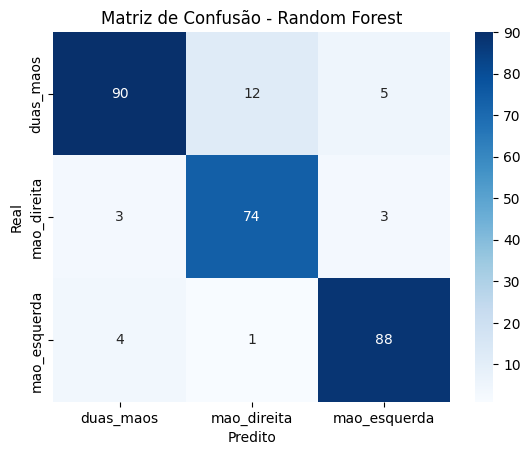

In [ ]:
# melhor resultado pro RF
X_train, X_test, y_train, y_test, labels = data_train_test('2', filtro='media_movel', win_size=230, overlap=0.4, n_sigma=3, size_sample=250)
MLI_RF = MLInmetro(X_train, X_test, y_train, y_test, labels)
y_ped_RF = MLI_RF.RandomForest()[-1]

MLI_RF.ConfusionMatrix(y_ped_RF, 'Random Forest')

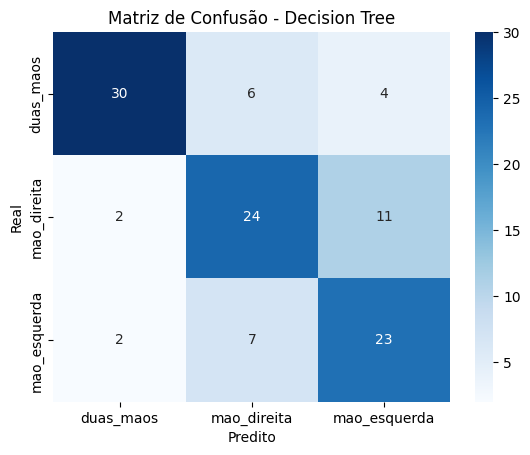

In [ ]:
# melhor resultado pro DT
X_train, X_test, y_train, y_test, labels = data_train_test('1', filtro='hampel', win_size=16, overlap=0.4, n_sigma=3, size_sample=190)
MLI_DT = MLInmetro(X_train, X_test, y_train, y_test, labels)
y_ped_DT = MLI_DT.DecisionTree()[-1]

MLI_DT.ConfusionMatrix(y_ped_DT, 'Decision Tree')

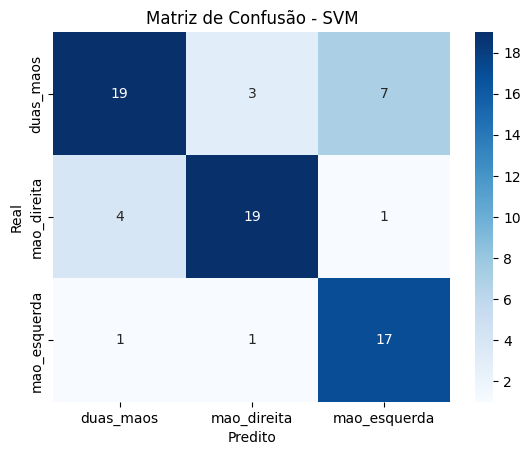

In [ ]:
# melhor resultado pro SVM
X_train, X_test, y_train, y_test, labels = data_train_test('1', filtro='media_movel', win_size=110, overlap=0.3, n_sigma=3, size_sample=250)
MLI_SVM = MLInmetro(X_train, X_test, y_train, y_test, labels)
y_ped_SVM = MLI_SVM.SVM()[-1]

MLI_SVM.ConfusionMatrix(y_ped_SVM, 'SVM')

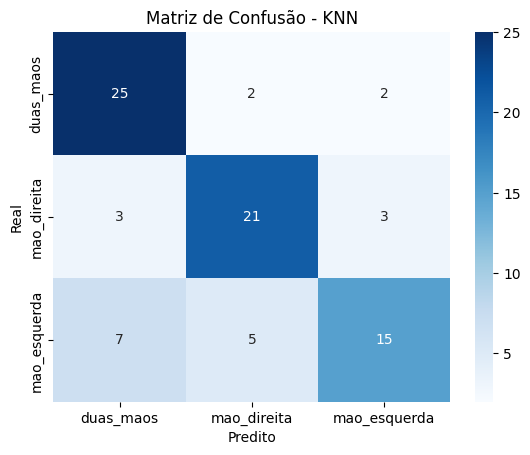

In [ ]:
# melhor resultado pro KNN
X_train, X_test, y_train, y_test, labels = data_train_test('1', filtro='media_movel', win_size=230, overlap=0.4, n_sigma=3, size_sample=250)
MLI_KNN = MLInmetro(X_train, X_test, y_train, y_test, labels)
y_ped_KNN= MLI_KNN.KNN()[-1]

MLI_KNN.ConfusionMatrix(y_ped_KNN, 'KNN')

In [ ]:
MLI_SVM.SVM()

(0.7638888888888888,
 0.7622017545993861,
 array([2, 0, 1, 2, 2, 0, 2, 0, 2, 2, 1, 0, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0,
        0, 2, 0, 0, 2, 1, 2, 0, 1, 0, 2, 1, 0, 0, 1, 0, 1, 1, 1, 2, 2, 0,
        2, 2, 1, 1, 0, 2, 2, 2, 2, 0, 2, 2, 0, 1, 0, 0, 2, 2, 1, 1, 0, 1,
        1, 1, 1, 2, 2, 0], dtype=int8))

In [ ]:
pip install qrcode[pil]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.2 MB/s eta 0:00:00


In [ ]:
import qrcode

# URL do repositório GitHub
url = "https://github.com/josewilsonsouza/Machine_Learing_INMETRO"

# Gerar QR code
qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)
qr.add_data(url)
qr.make(fit=True)

# Criar imagem do QR code
img = qr.make_image(fill='black', back_color='white')

# Salvar imagem
img.save("qrcode.pdf", format='pdf', bbox_inches='tight', pad_inches=0)